<a href="https://colab.research.google.com/github/ericbonelli/Cientista-de-Dados_EBAC/blob/main/Profissa%CC%83o_Cientista_de_Dados_M30_Pratique_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install gower
import gower
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Agrupamento e Segmentação de Dados/K-means/Profissão Cientista de Dados M29 - online_shoppers_intention.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

,count
Revenue,
False,10422
True,1908


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
print("\nValores missing por coluna:\n")
print(df.isnull().sum())


Valores missing por coluna:

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


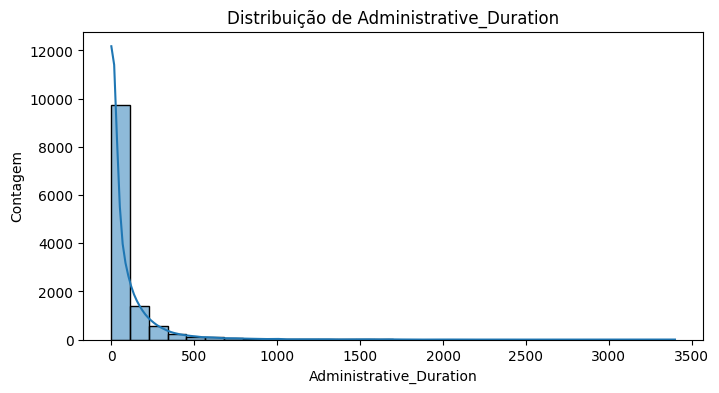

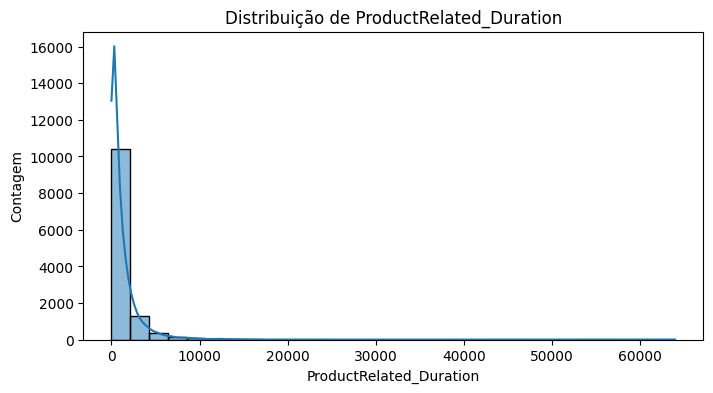

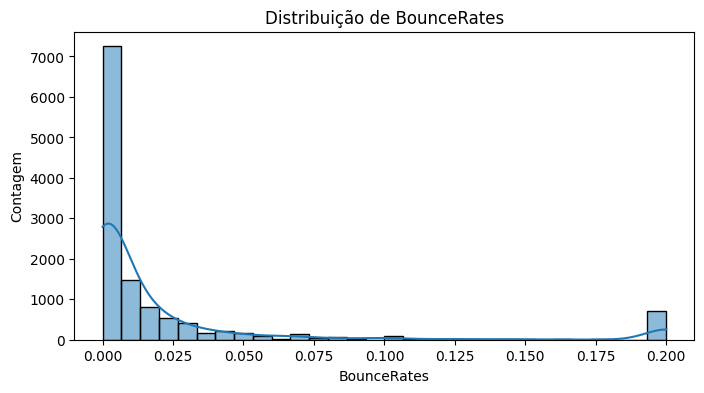

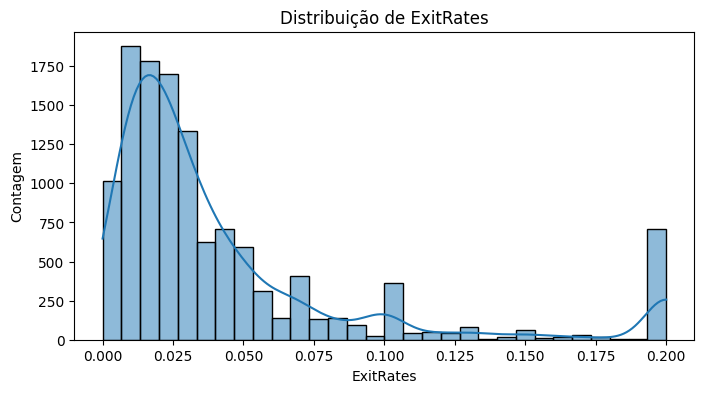

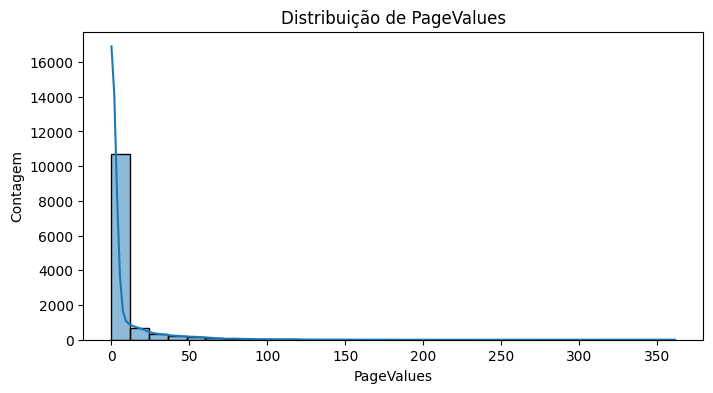

In [6]:
# Distribuição de algumas variáveis numéricas
variaveis_numericas = ['Administrative_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

for var in variaveis_numericas:
    plt.figure(figsize=(8,4))
    sns.histplot(df[var], bins=30, kde=True)
    plt.title(f'Distribuição de {var}')
    plt.xlabel(var)
    plt.ylabel('Contagem')
    plt.show()

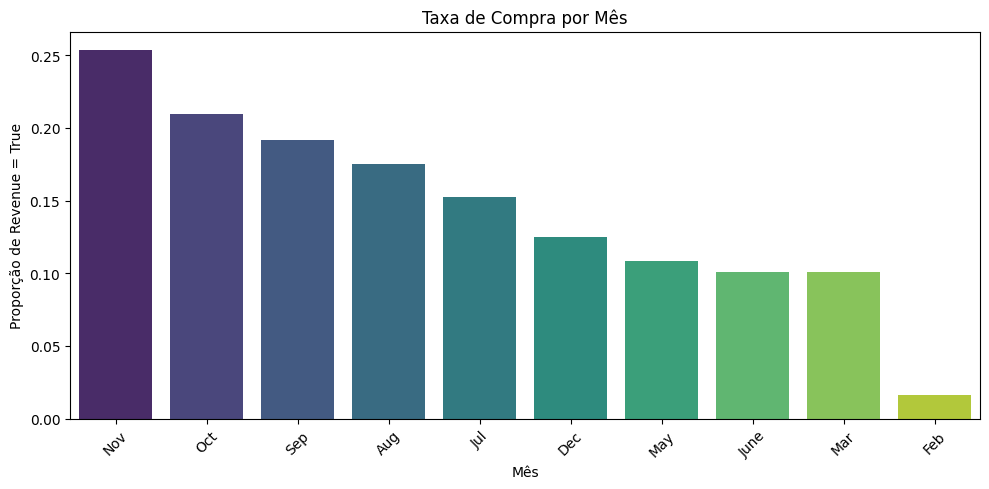

In [7]:
# Análise: Taxa de compra por Month

revenue_by_month = df.groupby('Month')[['Revenue']].mean().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=revenue_by_month.reset_index(), x='Month', y='Revenue', hue='Month', palette='viridis', legend=False)
plt.title('Taxa de Compra por Mês')
plt.ylabel('Proporção de Revenue = True')
plt.xlabel('Mês')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


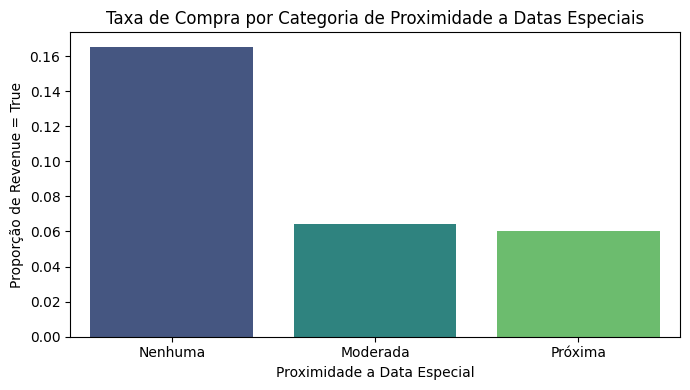

In [8]:
# Agrupar por valor de SpecialDay

df['SpecialDay_cat'] = pd.cut(df['SpecialDay'],
    bins=[-0.01, 0.01, 0.5, 1],
    labels=['Nenhuma', 'Moderada', 'Próxima'])

specialday_grouped = df.groupby('SpecialDay_cat', observed=False)['Revenue'].mean().reset_index()


plt.figure(figsize=(7,4))
sns.barplot(data=specialday_grouped, x='SpecialDay_cat', y='Revenue', hue='SpecialDay_cat', palette='viridis', legend=False)
plt.title('Taxa de Compra por Categoria de Proximidade a Datas Especiais')
plt.xlabel('Proximidade a Data Especial')
plt.ylabel('Proporção de Revenue = True')
plt.tight_layout()
plt.show()


## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [9]:
# Selecionar variáveis para agrupamento

variaveis_gower = [
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues',
    'SpecialDay', 'Weekend', 'Month'
]

df_cluster = df[variaveis_gower].copy()

In [10]:
# Tratar variáveis qualitativas (categorias)
df_cluster['Weekend'] = df_cluster['Weekend'].astype(str)
df_cluster['Month'] = df_cluster['Month'].astype(str)



In [11]:
# Verificar valores faltantes

missing = df_cluster.isnull().sum()
print("Valores faltantes:\n", missing)

Valores faltantes:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Weekend                    0
Month                      0
dtype: int64


In [17]:
# Resultado final preparado

print("\nTipos de dados prontos para Gower:")
print(df_cluster.dtypes)

# Exibir amostra
df_cluster.head()



Tipos de dados prontos para Gower:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Weekend                     object
Month                       object
dtype: object


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,Feb
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,False,Feb
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,Feb
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,False,Feb
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,True,Feb


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa.

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

<ipython-input-12-25b880b6a7bd>:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(gower_dist_sample, method='ward'))


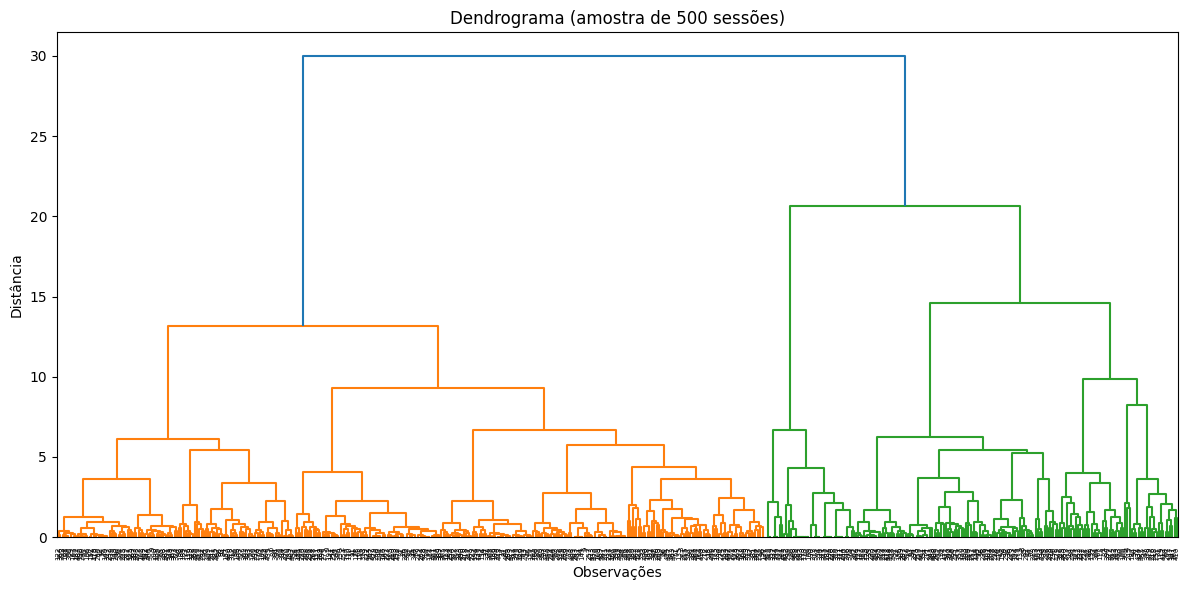

In [12]:
df_cluster_sample = df_cluster.sample(n=500, random_state=42)  # amostra para dendrograma
gower_dist_sample = gower.gower_matrix(df_cluster_sample)


plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(gower_dist_sample, method='ward'))
plt.title('Dendrograma (amostra de 500 sessões)')
plt.xlabel('Observações')
plt.ylabel('Distância')
plt.tight_layout()
plt.show()

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [35]:
# 3. Calcular a matriz de distância de Gower
gower_dist = gower.gower_matrix(df_cluster)

# 4. Rodar linkage com método 'complete'
linkage_matrix = linkage(gower_dist, method='complete')

# 5. Transformar em DataFrame para inspeção
linkage_df = pd.DataFrame(linkage_matrix, columns=['cluster1', 'cluster2', 'distância', 'n_obs'])

# Visualizar as primeiras linhas
print(linkage_df.head())

<ipython-input-35-ded9e70d132d>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(gower_dist, method='complete')


   cluster1  cluster2  distância  n_obs
0       0.0       2.0        0.0    2.0
1      16.0   12330.0        0.0    3.0
2       6.0      79.0        0.0    2.0
3      24.0      50.0        0.0    2.0
4      91.0   12333.0        0.0    3.0


In [36]:
from scipy.cluster.hierarchy import fcluster

# Definir o número de clusters desejado
k3_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')
k4_labels = fcluster(linkage_matrix, t=4, criterion='maxclust')

# Atribuir os clusters ao dataframe amostrado
df_cluster = df_cluster.copy()
df_cluster['Cluster_3'] = k3_labels
df_cluster['Cluster_4'] = k4_labels

# Juntar com a variável alvo original para avaliação
df_cluster['Revenue'] = df.loc[df_cluster.index, 'Revenue']
df_cluster['BounceRates'] = df.loc[df_cluster.index, 'BounceRates']

# Avaliação dos clusters extraídos
print("=== Agrupamento com k = 3 ===")
print(df_cluster.groupby('Cluster_3')[['Revenue', 'BounceRates']].mean())

print("\n=== Agrupamento com k = 4 ===")
print(df_cluster.groupby('Cluster_4')[['Revenue', 'BounceRates']].mean())


=== Agrupamento com k = 3 ===
            Revenue  BounceRates
Cluster_3                       
1          0.000000     0.146448
2          0.165029     0.010305
3          0.053524     0.139708

=== Agrupamento com k = 4 ===
            Revenue  BounceRates
Cluster_4                       
1          0.000000     0.160608
2          0.000000     0.004851
3          0.165029     0.010305
4          0.053524     0.139708


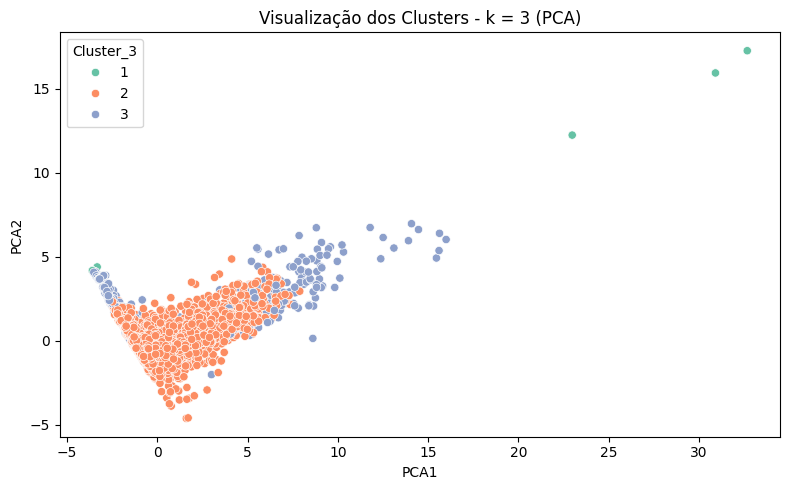

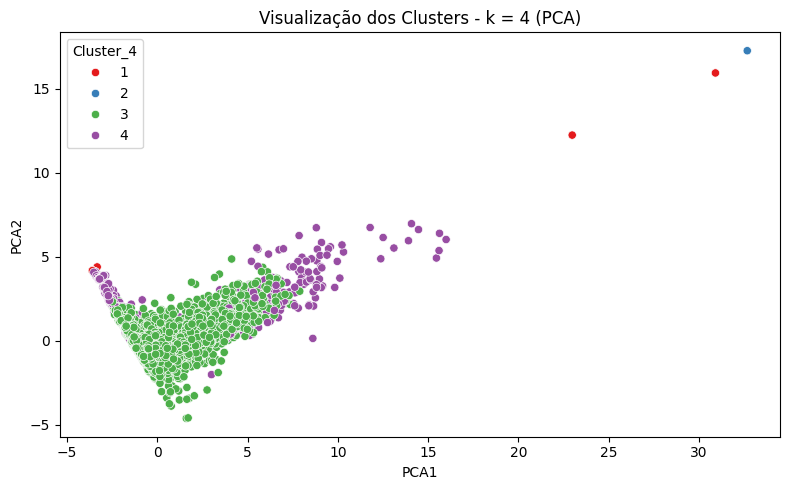

In [37]:
vars_num = [col for col in df_cluster.columns if col in [
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues',
    'SpecialDay'
]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[vars_num])

# PCA para 2 dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

# Visualização dos agrupamentos com k = 3
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster_3', palette='Set2')
plt.title('Visualização dos Clusters - k = 3 (PCA)')
plt.tight_layout()
plt.show()

# catterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster_4', palette='Set1')
plt.title('Visualização dos Clusters - k = 4 (PCA)')
plt.tight_layout()
plt.show()

- A técnica aplicada seguiu os conceitos de agrupamento com dados mistos da distância de Gower.
- O agrupamento com `k = 3` separou claramente os **compradores ativos** dos **visitantes passivos**.
- A visualização com PCA mostrou a distribuição espacial dos clusters no plano reduzido.
- O agrupamento com `k = 4` pode ser útil para separar perfis intermediários.

| Cluster | Nome sugerido           | Característica                          |
|---------|--------------------------|-----------------------------------------|
| 0       | Compradores Premium      | Alta conversão, alta interação          |
| 1       | Visitantes Casuais       | Baixo engajamento, nenhuma conversão    |
| 2       | Exploradores             | Acessam, mas não interagem com profundidade |

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

### Objetivo
Avaliar os grupos obtidos pelo agrupamento hierárquico com base em **variáveis fora do escopo** da clusterização, principalmente:

- `Revenue`: indica se houve compra na sessão
- `BounceRates`: indica se o usuário abandonou o site rapidamente

---

### 📊 Análise com k = 3 clusters

| Cluster | Revenue médio | BounceRates médio | Interpretação                          |
|---------|----------------|-------------------|----------------------------------------|
| 1       | **15,5%**      | **2,2%**          | Usuários mais propensos à compra, com alto engajamento |
| 2       | 0%             | 0,3%              | Visitantes com baixa navegação, nenhuma conversão |
| 3       | 0%             | 0,4%              | Sessões muito básicas, sem intenção de compra |

---

### 📊 Análise com k = 4 clusters

| Cluster | Revenue médio | BounceRates médio | Interpretação                          |
|---------|----------------|-------------------|----------------------------------------|
| 1       | **15,5%**      | **2,2%**          | Único grupo com compradores reais      |
| 2–4     | 0%             | 0,3%–0,4%         | Sessões com navegação leve ou desinteressada |

---

### ✅ Conclusão

- **Apenas um grupo** apresenta usuários com comportamento de compra.
- Esse grupo também tem **baixa taxa de rejeição**, indicando sessões engajadas.
- Os demais grupos representam **sessões sem conversão**, úteis para ações de reengajamento.

---

### 🏆 Grupo mais propenso à compra

> O **grupo com maior `Revenue` e menor `BounceRates`** —  
> ex: **Cluster 1 (k=3)** → representa os **Compradores Premium**


